In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import IPython.display as ipd
import pyximport
pyximport.install()
%load_ext Cython
import sigkernel as ksig
from utils.data import *
from model.generators import *

In [2]:
hist_len = 10
sample_len = 30 #NOTE it includes the hist_len
noise_dim = 3
seq_dim = 3 # (gap, duration, pitch)
scale = 1.
stride = 10
# max_pitch = 32
# pitch_offset = 37
key = 'oldies'

sigma = 1.0
kernel_type = 'truncated'
dyadic_order = 3
n_levels = 5
order = 1

batch_size = 64
activation = 'Tanh'
hidden_size = 64
n_layers = 1

In [3]:
with open(f'./data/dataframes/{key}/dfs.pkl', 'rb') as f:
    dfs = pickle.load(f)

Min pitch: 44
Max pitch: 90


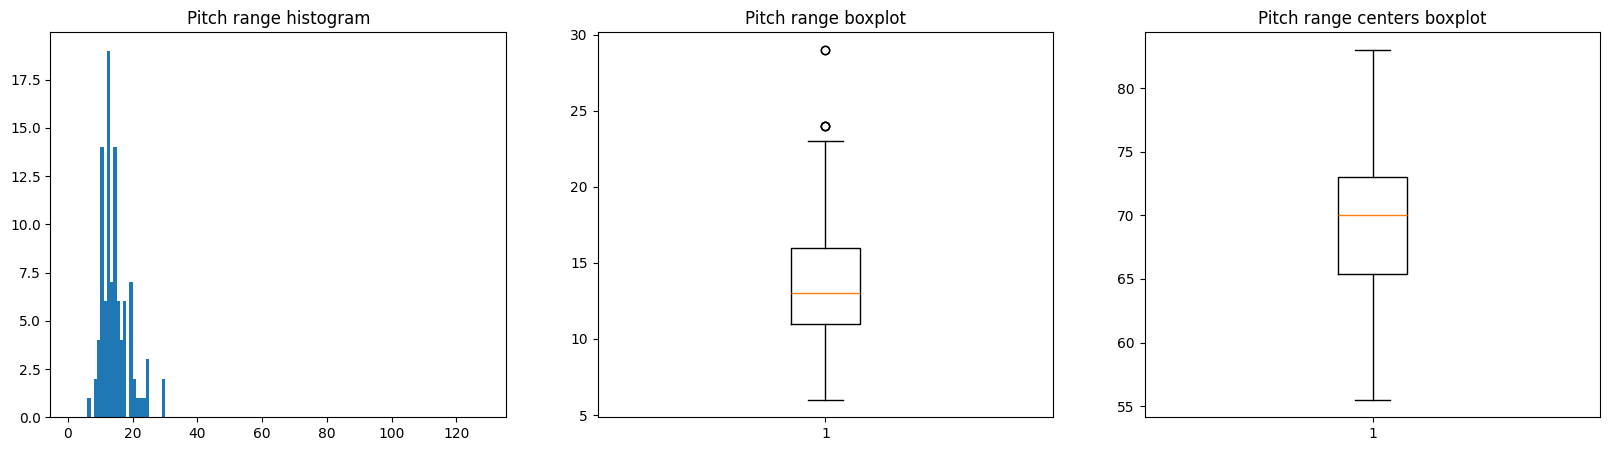

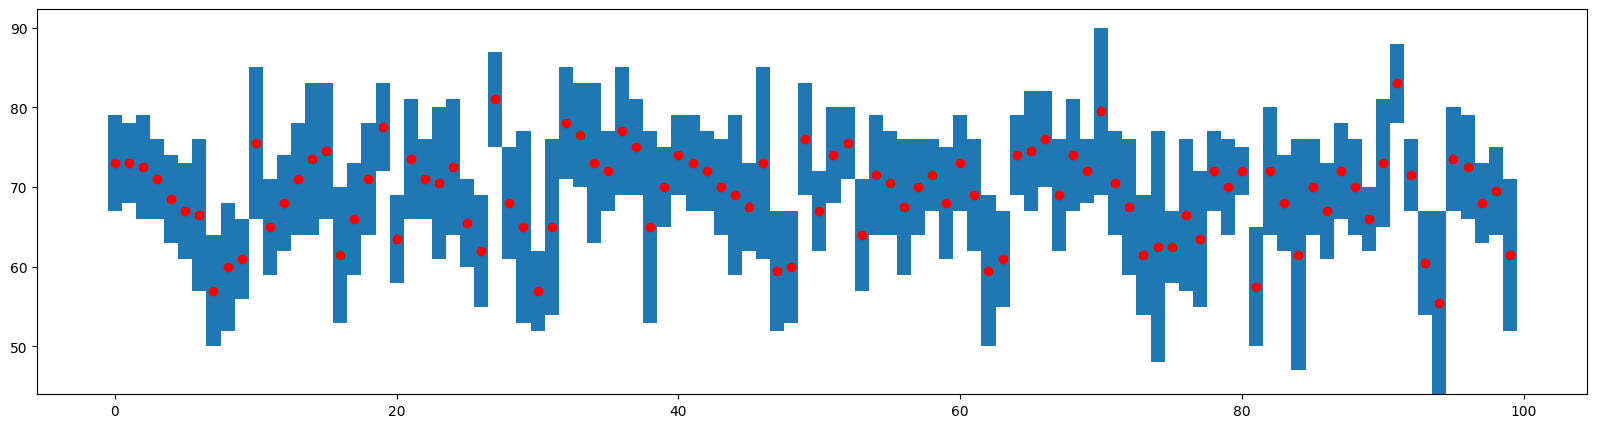

(44, 90)

In [4]:
pitch_range(dfs)

In [5]:
gap_dur_dpitch_dfs = gap_duration_deltapitch_transform(dfs)
dataset = GapDurationDeltaPitchDataset(gap_dur_dpitch_dfs, 30)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataset), len(dataloader)

(2315, 37)

In [6]:
generator = LSTMinc(noise_dim, seq_dim, sample_len, hidden_size, n_layers, activation)
generator = generator.cuda()
optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1, verbose=True)

In [7]:
if kernel_type == 'truncated':
    static_kernel = ksig.static.kernels.RationalQuadraticKernel(sigma=sigma)
    kernel = ksig.kernels.SignatureKernel(n_levels=n_levels, order=order, normalization=0, static_kernel=static_kernel, device_ids=None)
elif kernel_type == 'pde':
    static_kernel = ksig.sigkernelpde.RationalQuadraticKernel(sigma=sigma, alpha=1.0)
    kernel = ksig.sigkernelpde.SigKernelPDE(static_kernel, dyadic_order)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for epoch in range(30):
    losses = []
    for batch_num, X in enumerate(tqdm(dataloader)):
        X = X.to(device)
        X_rect = batch_rectilinear_with_gap_transform(X[:, hist_len:, :])

        int_noise = torch.randint(0, 12, (X.shape[0], 1)).to(device)
        int_noise = int_noise.float().repeat(1, X.shape[1]-1).unsqueeze(-1)
        gaussian_noise = torch.randn(X.shape[0], X.shape[1]-1, noise_dim-1).to(device)
        noise = torch.cat([int_noise, gaussian_noise], dim=-1)
        Y = generator(noise, X[:, :hist_len, :], X[:, hist_len:, :2])

        Y_rect = batch_rectilinear_with_gap_transform(Y[:, hist_len:, :])
        # print(output.shape, X.shape, X[:, :hist_len, :].shape)

        # compute loss
        optimizer.zero_grad()
        loss = ksig.tests.mmd_loss_no_compile(X_rect, Y_rect, kernel)
        losses.append(loss.item())

        # backpropagate and update weights
        loss.backward()
        optimizer.step()

    # log epoch loss and plot generated samples
    epoch_loss = np.average(losses) # average batch mmd for epoch
    scheduler.step(epoch_loss)
    print(f'Epoch {epoch+1}, loss: {epoch_loss}')

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:06<00:00,  6.01it/s]


Epoch 1, loss: 6.971601756843361


100%|██████████| 37/37 [00:05<00:00,  6.40it/s]


Epoch 2, loss: 2.5326559479172164


100%|██████████| 37/37 [00:05<00:00,  6.41it/s]


Epoch 3, loss: 2.3604919330493823


100%|██████████| 37/37 [00:05<00:00,  6.40it/s]


Epoch 4, loss: 2.3611142442033097


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Epoch 5, loss: 2.1784206338830896


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Epoch 6, loss: 1.9549952842093803


100%|██████████| 37/37 [00:05<00:00,  6.39it/s]


Epoch 7, loss: 1.8323365288811762


100%|██████████| 37/37 [00:05<00:00,  6.33it/s]


Epoch 8, loss: 2.151294424727156


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Epoch 9, loss: 2.1609568982510954


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Epoch 10, loss: 1.821850132297825


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Epoch 11, loss: 1.6738769943649705


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Epoch 12, loss: 1.7515214713844094


100%|██████████| 37/37 [00:05<00:00,  6.21it/s]


Epoch 13, loss: 3.067053691760914


100%|██████████| 37/37 [00:05<00:00,  6.28it/s]


Epoch 14, loss: 2.224443925393594


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.
Epoch 15, loss: 1.792328267484098


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Epoch 16, loss: 1.793030274880899


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Epoch 17, loss: 1.7586247469927814


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Epoch 18, loss: 1.5937222145699166


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Epoch 19, loss: 1.667929932877824


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Epoch 20, loss: 1.6307801684817753


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Epoch 21, loss: 1.5626706561526738


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Epoch 22, loss: 1.5382457423854519


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Epoch 23, loss: 1.6741135571454022


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Epoch 24, loss: 1.5768118935662347


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Epoch 25, loss: 1.7179334743602857


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Epoch 00026: reducing learning rate of group 0 to 1.0000e-05.
Epoch 26, loss: 1.6350021362304688


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Epoch 27, loss: 1.5256510296383419


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Epoch 28, loss: 1.5803376532889701


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Epoch 29, loss: 1.7012944608121305


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]

Epoch 30, loss: 1.4271992863835514


In [11]:
X_dfs = batch_gap_duration_pitch_to_df(X)
Y_dfs = batch_gap_duration_pitch_to_df(Y)

In [12]:
sample_idx = 1

In [13]:
input_midi = df_to_midi(X_dfs[sample_idx])
output_midi = df_to_midi(Y_dfs[sample_idx])

In [18]:
pd.merge(X_dfs[sample_idx][['Start', 'End', 'Pitch']], Y_dfs[sample_idx][['Pitch']], left_index=True, right_index=True)

,Start,End,Pitch_x,Pitch_y
0,0.000000,0.434783,60.0,60.0
1,0.434783,0.869566,60.0,60.0
2,0.869566,1.304349,64.0,64.0
3,1.304349,1.739132,65.0,65.0
4,1.739132,2.173915,63.0,63.0
5,2.173915,2.826089,60.0,60.0
6,3.260872,3.478264,66.0,66.0
7,3.478264,3.913047,66.0,66.0
8,3.913047,4.347830,66.0,66.0
9,4.347830,4.782613,62.0,62.0


In [14]:
Fs = 22050
audio_data = input_midi.synthesize(fs=Fs)
ipd.Audio(audio_data, rate=Fs)

In [15]:
audio_data = output_midi.synthesize(fs=Fs)
ipd.Audio(audio_data, rate=Fs)